In [14]:
pip install Pillow

DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [4]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [5]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [6]:
pip install opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/ec/6c/fab8113424af5049f85717e8e527ca3773299a3c6b02506e66436e19874f/opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB 2.0 MB/s eta 0:00:19
   ---------------------------------------- 0.4/38.8 MB 6.1 MB/s eta 0:00:07
   - -------------------------------------- 1.4/38.8 MB 14.6 MB/s eta 0:00:03
   ---- ----------------------------------- 3.9/38.8 MB 27.9 MB/s eta 0:00:02
   ------ --------------------------------- 6.2/38.8 MB 36.3 MB/s eta 0:00:01
   -------- ------------------------------- 8.1/38.8 MB 39.8 MB/s eta 0:00:01
   --------- ------------------------------ 9.0/38.8 MB 33.9 MB/s eta 0:00:01
   ---------- ----------------------------- 10.1/38.8 MB 32.5 MB/s eta 0:00:01
   ----------- ---------------------------- 11.4/38.8 MB 38.5 MB/s eta 0:00:01
   ---

DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [75]:
# import packages
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image, ImageEnhance

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models

from skimage import feature, exposure 

import warnings
warnings.filterwarnings("ignore")

print('modules loaded')


modules loaded


In [61]:
data_path = r"<directory to data folder>" 

blight = []
common_rust = []
gray_leaf_spot = []
healthy = []

for subfolder in os.listdir(data_path):
    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
  
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        
        if subfolder == 'Blight':
            blight.append(image_path)
        elif subfolder == 'Common_Rust':
            common_rust.append(image_path)
        elif subfolder == 'Gray_Leaf_Spot':
            gray_leaf_spot.append(image_path)
        elif subfolder == 'Healthy':
            healthy.append(image_path)

# Create a dictionary to store all arrays
image_data = {
    'blight': blight,
    'common_rust': common_rust,
    'gray_leaf_spot': gray_leaf_spot,
    'healthy': healthy
}

# Create a DataFrame for overview
data = pd.DataFrame({
    'blight': pd.Series(blight),
    'common_rust': pd.Series(common_rust),
    'gray_leaf_spot': pd.Series(gray_leaf_spot),
    'healthy': pd.Series(healthy)
})


In [62]:
data.head()

,blight,common_rust,gray_leaf_spot,healthy
0,C:\Users\USER\OneDrive - Universiti Teknologi ...,C:\Users\USER\OneDrive - Universiti Teknologi ...,C:\Users\USER\OneDrive - Universiti Teknologi ...,C:\Users\USER\OneDrive - Universiti Teknologi ...
1,C:\Users\USER\OneDrive - Universiti Teknologi ...,C:\Users\USER\OneDrive - Universiti Teknologi ...,C:\Users\USER\OneDrive - Universiti Teknologi ...,C:\Users\USER\OneDrive - Universiti Teknologi ...
2,C:\Users\USER\OneDrive - Universiti Teknologi ...,C:\Users\USER\OneDrive - Universiti Teknologi ...,C:\Users\USER\OneDrive - Universiti Teknologi ...,C:\Users\USER\OneDrive - Universiti Teknologi ...
3,C:\Users\USER\OneDrive - Universiti Teknologi ...,C:\Users\USER\OneDrive - Universiti Teknologi ...,C:\Users\USER\OneDrive - Universiti Teknologi ...,C:\Users\USER\OneDrive - Universiti Teknologi ...
4,C:\Users\USER\OneDrive - Universiti Teknologi ...,C:\Users\USER\OneDrive - Universiti Teknologi ...,C:\Users\USER\OneDrive - Universiti Teknologi ...,C:\Users\USER\OneDrive - Universiti Teknologi ...


In [63]:
data.shape

(1306, 4)

In [64]:
# Path to save the processed images
processed_data_path = r"<directory to processed_image folder>"

# Create a mapping from label to folder name
label_to_folder = {
    'blight': 'blight',
    'common_rust': 'common_rust',
    'gray_leaf_spot': 'gray_leaf_spot',
    'healthy': 'healthy'
}

In [65]:
# Image enhancement 
def image_enhancement(ori_image):
    # Convert color if necessary
    image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB)
        
    # Color Correction
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab_image)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l_channel)
    limg = cv2.merge((cl, a_channel, b_channel))
    corrected_image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
        
    # Contrast enhancement
    pil_image = Image.fromarray(corrected_image)
    enhancer = ImageEnhance.Contrast(pil_image)
    enhanced_image = enhancer.enhance(1.5)  # Enhance contrast by a factor of 1.5
    
    # Convert back to numpy array (RGB)
    final_image = np.array(enhanced_image)

    # Pad the image to make it square
    final_image = pad_to_square(final_image)
        
    # Resize image to target size
    img_size = (256, 256)
    resized_image = cv2.resize(final_image, img_size)
    
    return resized_image
    

In [66]:
# Function to add padding to the image to make it square
def pad_to_square(image):
    height, width, _ = image.shape
    max_dim = max(height, width)
    top = (max_dim - height) // 2
    bottom = max_dim - height - top
    left = (max_dim - width) // 2
    right = max_dim - width - left
    padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded_image

In [67]:
# Texture Extraction - Technique 2
def image_processing(image_path):
    # Load and preprocess image
    ori_image = cv2.imread(image_path)
    
    # Perform image enhancement first
    resized_image = image_enhancement(ori_image)
    
    # Extract texture features using Local Binary Pattern (LBP)
    texture_features = extract_texture_features(resized_image)
    
    return ori_image, texture_features


In [70]:
# Function focus extract the texture using LBP
def extract_texture_features(image):
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Compute Local Binary Pattern (LBP) features
    lbp_radius = 3
    lbp_points = 24
    lbp = feature.local_binary_pattern(gray_image, lbp_points, lbp_radius, method='uniform')
    
    # Calculate histogram of LBP and normalize it
    hist_lbp, _ = np.histogram(lbp.ravel(), bins=np.arange(0, lbp_points + 3), range=(0, lbp_points + 2))
    hist_lbp = hist_lbp.astype("float")
    hist_lbp /= (hist_lbp.sum() + 1e-7)
    
    return hist_lbp

In [71]:
# List to store image paths and corresponding texture features
processed_data = []

# Iterate over each image path and extract features
for label, paths in image_data.items():
    print(f"Processing {label} images...")
    for idx, image_path in enumerate(paths):
        print(f"\rProcessing image {idx + 1}/{len(paths)}", end='')
        original_image, texture_features = image_processing(image_path)
        processed_data.append({'image_path': image_path, 'label': label, 'texture_features': texture_features})
    print()  # To move to the next line after completing processing of label images

# Convert processed_data to DataFrame for easier manipulation
processed_df = pd.DataFrame(processed_data)

# Save DataFrame to CSV for later use
processed_df.to_csv(r'<directory to processed_texture_features.csv>', index=False)

print("Processing complete. CSV file saved.")


Processing blight images...
Processing image 1146/1146
Processing common_rust images...
Processing image 1306/1306
Processing gray_leaf_spot images...
Processing image 574/574
Processing healthy images...
Processing image 1162/1162
Processing complete. CSV file saved.


In [76]:
# Load processed data from CSV
processed_df = pd.read_csv(r'<directory to processed_texture_features.csv>)

# Convert texture features column from string to list
processed_df['texture_features'] = processed_df['texture_features'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))

# Prepare feature and label arrays
X = np.vstack(processed_df['texture_features'].values)
label_to_index = {label: idx for idx, label in enumerate(processed_df['label'].unique())}
y = np.array([label_to_index[label] for label in processed_df['label']])

# Normalize features
X = (X - X.mean(axis=0)) / X.std(axis=0)

print("Label to Index Mapping:")
for label, index in label_to_index.items():
    print(f"{label}: {index}")

Label to Index Mapping:
blight: 0
common_rust: 1
gray_leaf_spot: 2
healthy: 3


In [77]:
# Split the dataset into train (85%), validation (7.5%), and test (7.5%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.85, shuffle=True, random_state=123, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, train_size=0.5, shuffle=True, random_state=123, stratify=y_temp)

# Display the sizes of each dataset
print(f"Number of samples in train set: {len(X_train)}")
print(f"Number of samples in validation set: {len(X_valid)}")
print(f"Number of samples in test set: {len(X_test)}")

Number of samples in train set: 3559
Number of samples in validation set: 314
Number of samples in test set: 315


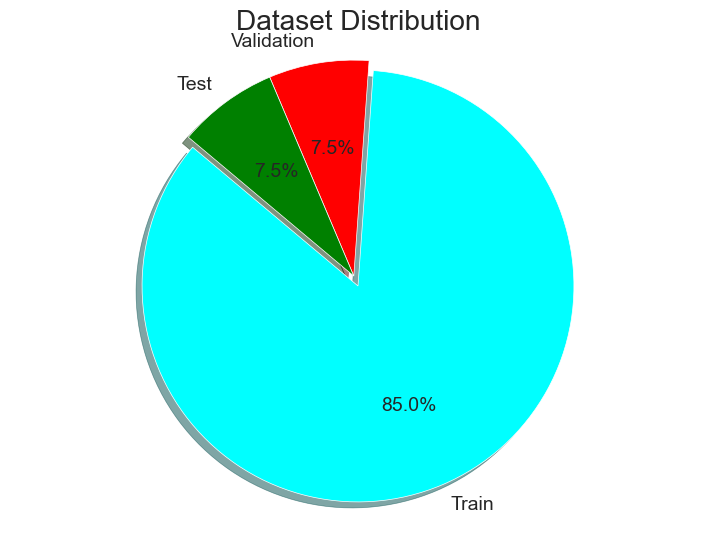

<Figure size 640x480 with 0 Axes>

In [78]:
# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie([len(X_train), len(X_valid), len(X_test)],
        labels=['Train', 'Validation', 'Test'],
        autopct='%.1f%%',
        colors=['aqua', 'red', 'green'],
        explode=(0.05, 0, 0),
        shadow=True,
        startangle=140)
plt.title('Dataset Distribution')
plt.axis('equal')
plt.show()

# Save the pie chart as an image
plt.savefig('dataset_pie.png')

In [79]:
# Define the model architecture
n_classes = len(label_to_index)
input_shape = X_train.shape[1]

model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(input_shape,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 128)               3456      
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 4)                 260       
                                                                 
Total params: 11972 (46.77 KB)
Trainable params: 11972 (46.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [80]:
from tensorflow.keras import callbacks

# Define a callback to stop training once validation accuracy reaches 98%
class myCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.98:
            print("\nReached 98% validation accuracy. Stopping training!")
            self.model.stop_training = True

callbacks = myCallback()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,  # Increased epochs for better training
    batch_size=32,
    verbose=1,
    validation_data=(X_valid, y_valid),
    callbacks=[callbacks]
)

Epoch 1/20
112/112 [==============================] - 1s 4ms/step - loss: 0.7147 - accuracy: 0.7384 - val_loss: 0.4649 - val_accuracy: 0.8089
Epoch 2/20
112/112 [==============================] - 0s 2ms/step - loss: 0.4462 - accuracy: 0.8272 - val_loss: 0.4003 - val_accuracy: 0.8153
Epoch 3/20
112/112 [==============================] - 0s 2ms/step - loss: 0.3995 - accuracy: 0.8398 - val_loss: 0.3855 - val_accuracy: 0.8408
Epoch 4/20
112/112 [==============================] - 0s 2ms/step - loss: 0.3734 - accuracy: 0.8500 - val_loss: 0.3670 - val_accuracy: 0.8503
Epoch 5/20
112/112 [==============================] - 0s 2ms/step - loss: 0.3642 - accuracy: 0.8511 - val_loss: 0.3514 - val_accuracy: 0.8503
Epoch 6/20
112/112 [==============================] - 0s 2ms/step - loss: 0.3469 - accuracy: 0.8620 - val_loss: 0.3391 - val_accuracy: 0.8726
Epoch 7/20
112/112 [==============================] - 0s 2ms/step - loss: 0.3386 - accuracy: 0.8640 - val_loss: 0.3504 - val_accuracy: 0.8535
Epoch 

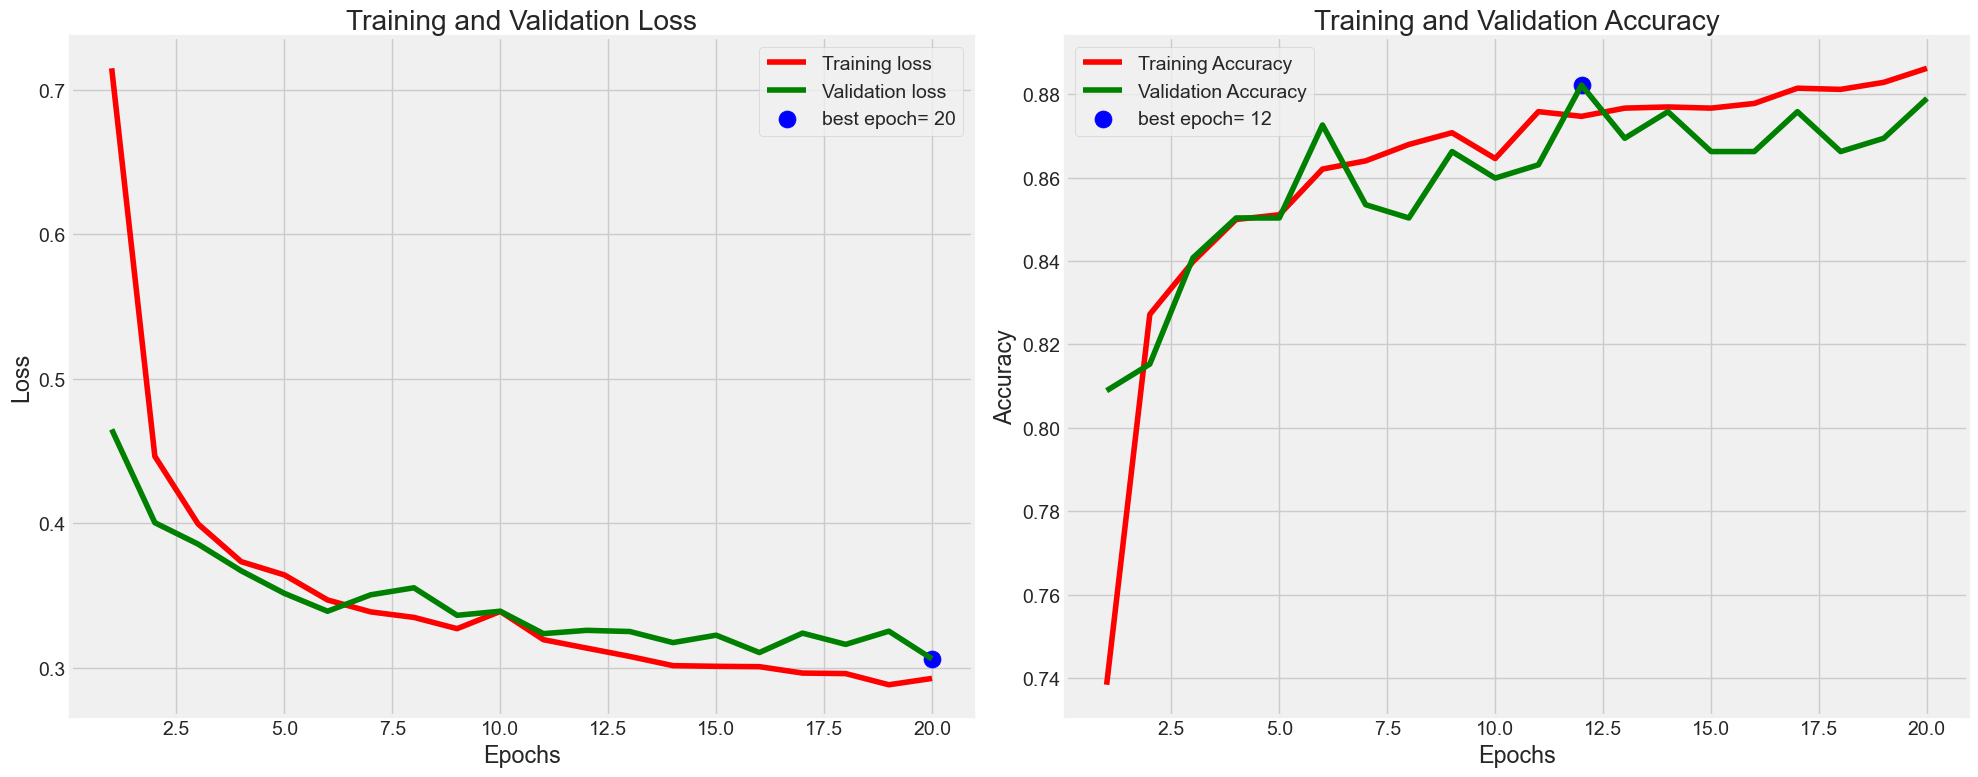

In [81]:
# Retrieve history data
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Identify best epoch based on validation loss and accuracy
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plotting training and validation loss
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [82]:
# Evaluate on validation data
loss, accuracy = model.evaluate(X_valid, y_valid)
print("Validation Accuracy:", accuracy)

10/10 [==============================] - 0s 2ms/step - loss: 0.3061 - accuracy: 0.8790
Validation Accuracy: 0.8789808750152588


In [84]:
# Evaluate on train, validation, and test datasets
train_score = model.evaluate(X_train, y_train, verbose=1)
valid_score = model.evaluate(X_valid, y_valid, verbose=1)
test_score = model.evaluate(X_test, y_test, verbose=1)

print("Train Loss:", train_score[0])
print("Train Accuracy:", train_score[1])
print('-' * 20)
print("Validation Loss:", valid_score[0])
print("Validation Accuracy:", valid_score[1])
print('-' * 20)
print("Test Loss:", test_score[0])
print("Test Accuracy:", test_score[1])

10/10 [==============================] - 0s 2ms/step - loss: 0.3290 - accuracy: 0.8603
Train Loss: 0.27434810996055603
Train Accuracy: 0.8881708383560181
--------------------
Validation Loss: 0.3061203360557556
Validation Accuracy: 0.8789808750152588
--------------------
Test Loss: 0.32897064089775085
Test Accuracy: 0.8603174686431885


In [85]:
# Predictions on test data
preds = model.predict(X_test)
y_pred = np.argmax(preds, axis=1)

10/10 [==============================] - 0s 2ms/step


In [86]:
# Classification report
print(classification_report(y_test, y_pred, target_names=[str(label) for label in label_to_index.keys()]))


                precision    recall  f1-score   support

        blight       0.72      0.88      0.80        86
   common_rust       0.97      0.97      0.97        98
gray_leaf_spot       0.69      0.51      0.59        43
       healthy       0.97      0.89      0.93        88

      accuracy                           0.86       315
     macro avg       0.84      0.81      0.82       315
  weighted avg       0.87      0.86      0.86       315



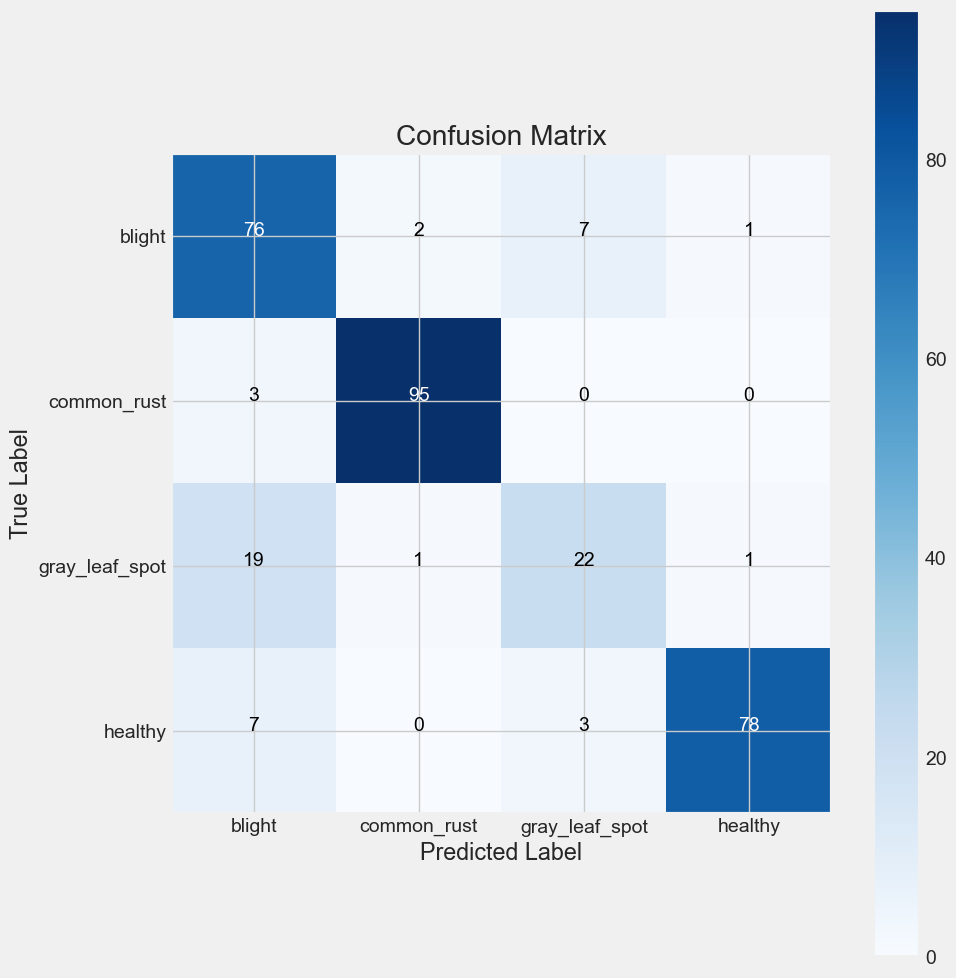

In [87]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
classes = list(label_to_index.keys())

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [88]:
# Model Save
model.save('modelTextureExtraction.h5')

1/1 [==============================] - 0s 113ms/step


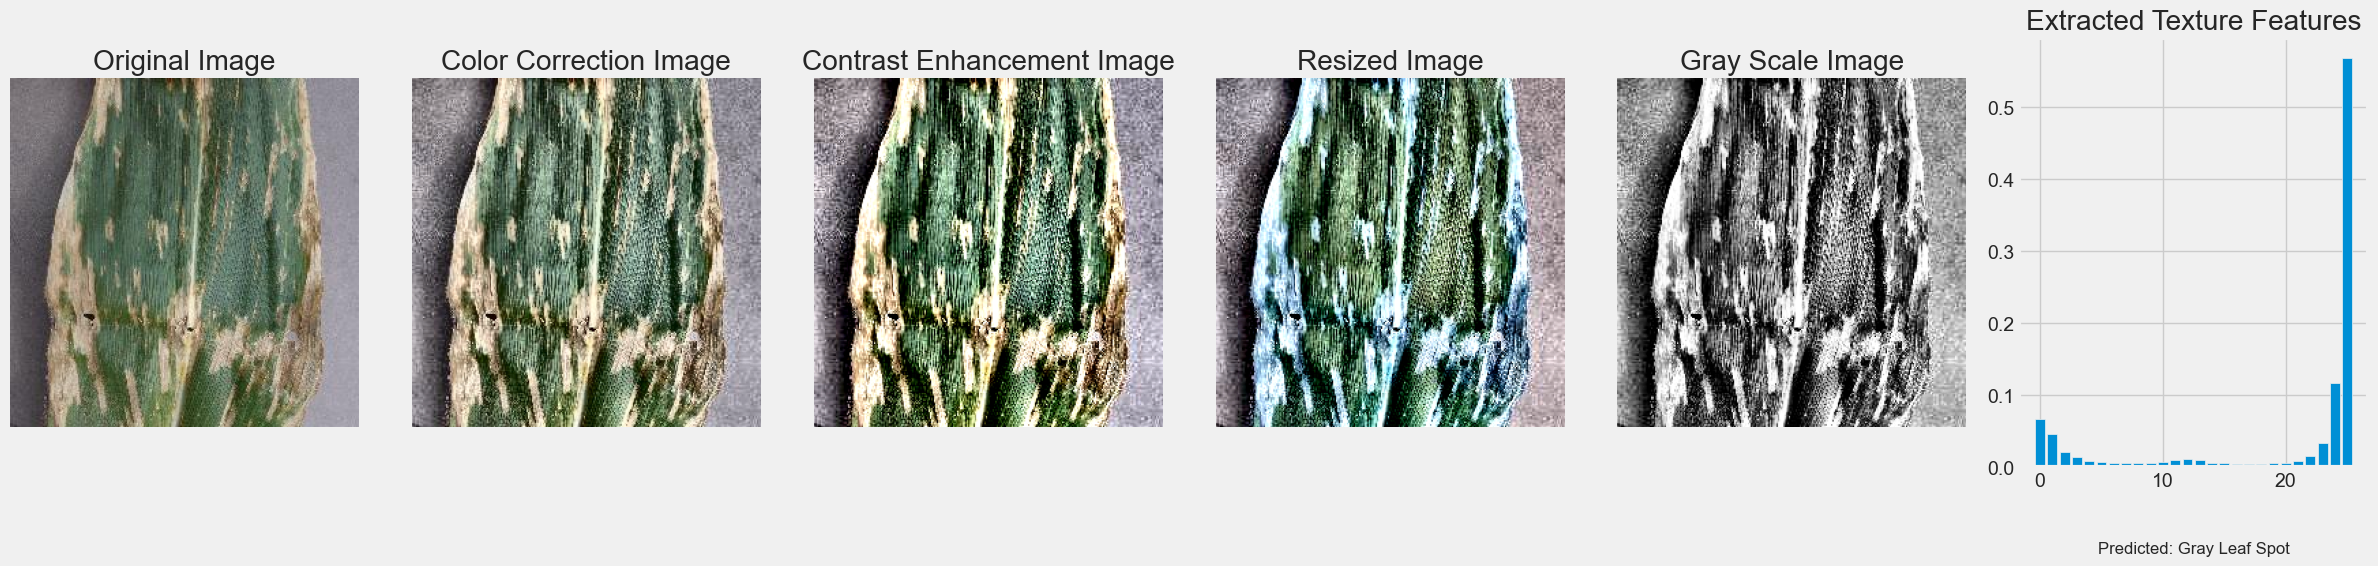

In [94]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from skimage import feature, exposure  # Importing feature for Local Binary Pattern (LBP)

# Load your trained model
model_path = 'modelTextureExtraction.h5'
model = load_model(model_path)

# Function to perform color correction
def upload_image_enhancement(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert color if necessary
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Color Correction
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab_image)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l_channel)
    limg = cv2.merge((cl, a_channel, b_channel))
    corrected_image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    
    # Contrast enhancement
    pil_image = Image.fromarray(corrected_image)
    enhancer = ImageEnhance.Contrast(pil_image)
    enhanced_image = enhancer.enhance(1.5)  # Enhance contrast by a factor of 1.5
    
    # Convert back to numpy array (RGB)
    final_image = np.array(enhanced_image)

    # Pad the image to make it square
    final_image = pad_to_square(final_image)
    
    # Resize image to target size
    img_size = (256, 256)
    resized_image = cv2.resize(final_image, img_size)
    resized_image = cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR)
    
    return image, corrected_image, enhanced_image, resized_image

# Function to add padding to the image to make it square
def pad_to_square(image):
    height, width, _ = image.shape
    max_dim = max(height, width)
    top = (max_dim - height) // 2
    bottom = max_dim - height - top
    left = (max_dim - width) // 2
    right = max_dim - width - left
    padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded_image

def texture_extraction(enhanced_image):
    # Convert image to grayscale
    gray_image = cv2.cvtColor(enhanced_image, cv2.COLOR_RGB2GRAY)
    
    # Compute Local Binary Pattern (LBP) features
    lbp_radius = 3
    lbp_points = 24
    lbp = feature.local_binary_pattern(gray_image, lbp_points, lbp_radius, method='uniform')
    
    # Calculate histogram of LBP and normalize it
    hist_lbp, _ = np.histogram(lbp.ravel(), bins=np.arange(0, lbp_points + 3), range=(0, lbp_points + 2))
    hist_lbp = hist_lbp.astype("float")
    hist_lbp /= (hist_lbp.sum() + 1e-7)
    
    return gray_image, hist_lbp

# Function to predict using the loaded model
def predict_image(image_path, model):
    # Enhanced image
    original_image, corrected_image, enhanced_image, resized_image = upload_image_enhancement(image_path)

    # Display all images
    fig, axs = plt.subplots(1, 6, figsize=(24, 6))  # Increased to accommodate space for predicted label

    titles = ["Original Image", "Color Correction Image", "Contrast Enhancement Image", "Resized Image", "Gray Scale Image", "Extracted Texture Features"]
    
    axs[0].imshow(original_image)
    axs[0].set_title(titles[0])
    axs[0].axis("off")

    axs[1].imshow(corrected_image)
    axs[1].set_title(titles[1])
    axs[1].axis("off")

    axs[2].imshow(enhanced_image)
    axs[2].set_title(titles[2])
    axs[2].axis("off")

    axs[3].imshow(resized_image)
    axs[3].set_title(titles[3])
    axs[3].axis("off")

    # gray scale Image and texture features
    gray_scale_image, texture_features = texture_extraction(resized_image)
    axs[4].imshow(gray_scale_image, cmap='gray')  # Display grayscale image
    axs[4].set_title(titles[4])
    axs[4].axis("off")
    
    axs[5].bar(np.arange(len(texture_features)), texture_features)  # Display texture features histogram
    axs[5].set_title(titles[5])
    
    # Predict and display label
    prediction = model.predict(np.expand_dims(resized_image, axis=0))
    predicted_class = np.argmax(prediction, axis=-1)
    class_labels = {0: 'Blight', 1: 'Common Rust', 2: 'Gray Leaf Spot', 3: 'Healthy'}  # Update with your class labels
    predicted_label = class_labels[predicted_class[0]]

    axs[5].text(0.5, -0.2, f"Predicted: {predicted_label}", fontsize=12, ha='center', transform=axs[5].transAxes)
    
    plt.tight_layout()
    plt.show()
    
    return predicted_class

# Example usage:
image_path = r"<directory to specific image>"

predicted_class = predict_image(image_path, model)
